## Speech Scrambler — **Encoder**

This notebook implements a **frequency–band scrambling** encoder for a speech signal.
It divides the spectrum into equal-width bands, remaps them according to a chosen permutation, and saves the scrambled audio.

### How to use
1. We are setting 'INPUT_WAV' to our WAV file path. Recoding.wav file is already uploaded to the notebook.
2. We have to run all cells.
3. The scrambled audio will be saved as 'scrambled.wav' alongside visualizations (waveforms & spectrograms).

### Task (matches a common project variation)
- Number of bands **N = 7**
- Output order **[7, 5, 3, 1, 2, 4, 6]** (FIR, ~40 dB stopband)

# Speech Band-Scrambler — **Encoder Algorithm** (Explanation)

This page explains, in **plain words**, what the encoder code does and how each step fits together.

---

## Inputs & Configuration
- **`fs` / `sr`**: sampling rate of the input WAV.
- **`N_BANDS`**: number of equal-width frequency bands (e.g., 7).
- **`OUTPUT_ORDER`**: permutation specifying where each **source** band should go (1-based). Example: `[7,5,3,1,2,4,6]`.
- **Filter design knobs**:  
  - `min_stop_atten_db`: desired stopband attenuation (e.g., 40 dB).  
  - `transition_fraction`: fraction of each band's width set aside as transition region.

---

## 1) Build an Equal-Band **Filterbank**
**Functions:** `design_bandpass_fir`, `make_filterbank`

1. Compute **Nyquist**: \( f_N = \tfrac{fs}{2} \).
2. Split \([0, f_N]\) into **N** equal-width bands:  
   `band_edges = np.linspace(0.0, fs/2, N+1)`.
3. For each band \([f_{\text{lo}}, f_{\text{hi}}]\), design a **linear-phase FIR bandpass**:
   - Define a **transition width**: `tw = transition_fraction * (f_hi - f_lo)` and pull the passband edges inward to \([f_1, f_2] = [f_{\text{lo}}+tw,\, f_{\text{hi}}-tw]\)` (with a fallback if too narrow).
   - Compute **Kaiser β** from the requested attenuation `A` (≈ `min_stop_atten_db`).
   - Estimate **tap length** from attenuation and normalized transition width \(\Delta f\); enforce **odd** length (≥ 101) for linear-phase symmetry.
   - Design with `scipy.signal.firwin(..., pass_zero=False, window=('kaiser', beta))`.

**Why:** The filterbank isolates spectral energy into **N** slices with predictable, uniform phase delay.

---

## 2) **Analyze** the Input into Bands
**Function:** `analyze_bands`

For each filter \(h_k[n]\), compute the **band-limited** signal:
\[
b_k[n] \;=\; (x * h_k)[n]
\]
Result: `bands[k]` holds the portion of the signal that lies **inside** band \(k\).

**Why:** We need clean, separated band signals before we can move them to new locations.

---

## 3) **Scramble**: Shift Each Source Band to Its Target Band
**Function:** `scramble_bands`

For each **source** band index `src_idx`:
1. Determine the **target** band index:
   \[
\text{target\_band\_idx} = \text{OUTPUT\_ORDER[src\_idx]} - 1
\]
2. Compute **center frequencies**:
\[
f_{src,c}=\tfrac{f_{src,lo}+f_{src,hi}}{2}, \quad
f_{tgt,c}=\tfrac{f_{tgt,lo}+f_{tgt,hi}}{2}
\]
3. Compute **frequency shift**:
\[
\Delta f = f_{tgt,c} - f_{src,c}
\]
4. **Real cosine mixing** (heterodyning) to shift in frequency:
\[
y[n] \;=\; 2\cos\!\Big(2\pi \tfrac{\Delta f}{fs}\, n\Big)\; b_{src}[n]
\]
   - Real mixing creates **two images** at \(\pm \Delta f\). The factor **2** compensates the amplitude split so the desired image keeps similar level.
5. **Confine** to the **target band** with the target bandpass filter \(h_{\text{tgt}}\):
\[
\tilde{y}[n] \;=\; (y * h_{\text{tgt}})[n]
\]
   This removes the mirror image and out-of-band energy.
6. **Accumulate** into the output sum:
\[
\text{out}[n] \mathrel{+}= \tilde{y}[n]
\]

After processing all bands, `out` is the **scrambled** signal.

**Why:** Moving low-frequency speech content to high bands (and vice versa) breaks the natural relation between **pitch** and **formants**, making speech **unintelligible** while preserving the time structure.

---

## 4) **Visualize** (Optional)
**Function:** `plot_wave_and_spectrogram`

- **Waveform**: amplitude vs. time for a quick sanity check (levels, pauses, envelope).
- **Spectrogram** (STFT): shows the **striped** band structure with energy appearing in **re-assigned** frequency regions.

**Typical STFT settings**: `n_fft=2048`, `hop_length=512`. Color via `librosa.amplitude_to_db` for dB scaling.

---

## Design Notes & Practical Tips

- **Linear-phase FIR** ⇒ uniform delay across all bands; decoding re-aligns naturally (up to a constant delay \((\text{taps}-1)/2\)).
- **Attenuation vs. taps**: higher `min_stop_atten_db` → better isolation but **longer** filters (more CPU/latency).
- **Transition width**: smaller `transition_fraction` → sharper bands (longer filters); larger → shorter filters but more leakage.
- **Permutation choice**: use a **derangement** (no fixed points) for stronger scrambling; map low bands to the **highest** regions to harm intelligibility most.
- **Headroom**: when summing confined bands, leave space to avoid **clipping**; normalize if needed before saving.
- **Performance**: cost scales with **N × taps × signal_length**. Values like **N ≈ 7**, **~40 dB** attenuation keep it practical.

---

## TL;DR (Encoder)
**Filter → Analyze → Shift → Confine → Sum → Plot**  
Split the signal into bands, **shift** each band to its **target** center with a cosine mixer, **filter** into the target band to keep the desired image, **sum** all bands → **scrambled** audio ready to transmit/store.


In [9]:
import numpy as np
import librosa, librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter

# ---- User settings ----
INPUT_WAV = 'Recording.wav'  
OUTPUT_WAV = 'scrambled.wav'

# Scrambler configuration (Variation example: N=7, order=[7,5,3,1,2,4,6])
N_BANDS = 7
OUTPUT_ORDER = [7, 5, 3, 1, 2, 4, 6]  # 1..N indexing
MIN_STOP_ATTEN_DB = 40
TRANSITION_FRACTION = 0.12  # fraction of each band's width used for transition; tweak if needed

assert len(OUTPUT_ORDER) == N_BANDS and set(OUTPUT_ORDER) == set(range(1, N_BANDS+1)), (
    'OUTPUT_ORDER must be a permutation of 1..N_BANDS'
)

In [11]:
def design_bandpass_fir(fs, f_lo, f_hi, min_stop_atten_db=40, transition_fraction=0.12):
    """Design a linear-phase FIR bandpass via firwin with a Kaiser window.
    We pad the band by a small transition region and use kaiserord estimate for taps.
    """
    
    nyq = fs / 2.0    
    # Convert absolute Hz to normalized [0,1]
    width_hz = (f_hi - f_lo)
    tw = transition_fraction * width_hz
    f1 = max(0.0, f_lo + tw)
    f2 = min(nyq, f_hi - tw)
    if f2 <= f1:  # fall back if band is too narrow
        f1 = f_lo
        f2 = f_hi
        tw = max(1.0, 0.02*width_hz)

    # Kaiser beta estimate
    A = float(min_stop_atten_db)
    if A > 50:
        beta = 0.1102*(A-8.7)
    elif A >= 21:
        beta = 0.5842*(A-21)**0.4 + 0.07886*(A-21)
    else:
        beta = 0.0

    # Length estimate (kaiserord) in samples at Nyquist-normalized transition
    # Δf normalized (0..1) relative to Nyquist
    delta_f = max(1e-6, (tw/nyq))
    N_est = int(np.ceil((A - 8.0) / (2.285 * 2*np.pi*delta_f)))  # conservative
    numtaps = int(max(101, (N_est//2)*2 + 1))  # odd length >= 101

    # Use firwin bandpass (pass_zero=False)
    taps = firwin(numtaps, [f1/nyq, f2/nyq], pass_zero=False, window=('kaiser', beta))
    return taps

def make_filterbank(fs, N, min_stop_db=40, transition_fraction=0.12):
    nyq = fs/2
    band_edges = np.linspace(0.0, nyq, N+1)
    filters = []
    for k in range(N):
        f_lo, f_hi = band_edges[k], band_edges[k+1]
        taps = design_bandpass_fir(fs, f_lo, f_hi, min_stop_db, transition_fraction)
        filters.append((f_lo, f_hi, taps))
    return band_edges, filters

def center_frequency(f_lo, f_hi):
    return 0.5*(f_lo + f_hi)

def analyze_bands(x, filters):
    # Return list of band-limited signals
    bands = []
    for f_lo, f_hi, taps in filters:
        bands.append(lfilter(taps, [1.0], x))
    return bands

def scramble_bands(bands, band_edges, output_order, fs, filters):
    # Mix each input band to the target band's center and confine via target bandpass
    nyq = fs/2
    N = len(bands)
    out = np.zeros_like(bands[0])
    t = np.arange(len(out))
    for src_idx in range(N):
        target_band_idx = output_order[src_idx] - 1  # convert 1..N -> 0-based
        src_lo, src_hi = band_edges[src_idx], band_edges[src_idx+1]
        tgt_lo, tgt_hi = band_edges[target_band_idx], band_edges[target_band_idx+1]
        f_src_c = center_frequency(src_lo, src_hi)
        f_tgt_c = center_frequency(tgt_lo, tgt_hi)
        delta_f = f_tgt_c - f_src_c
        # Real cosine mixer (image appears on ±), then confine with target bandpass
        mixer = 2.0*np.cos(2*np.pi*delta_f * t / fs)
        shifted = bands[src_idx] * mixer
        # Confine to target band using the target filter taps
        tgt_taps = filters[target_band_idx][2]
        confined = lfilter(tgt_taps, [1.0], shifted)
        out += confined
    return out

def plot_wave_and_spectrogram(y, sr, title_prefix):
    plt.figure()
    plt.title(f"{title_prefix} — Waveform")
    plt.plot(np.arange(len(y))/sr, y)
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.tight_layout()

    D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
    DB = librosa.amplitude_to_db(D, ref=np.max)
    plt.figure()
    librosa.display.specshow(DB, sr=sr, hop_length=512, x_axis='time', y_axis='linear')
    plt.title(f"{title_prefix} — Spectrogram (linear freq)")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()


Loaded: Recording.wav | sr=44100 | duration=14.07s


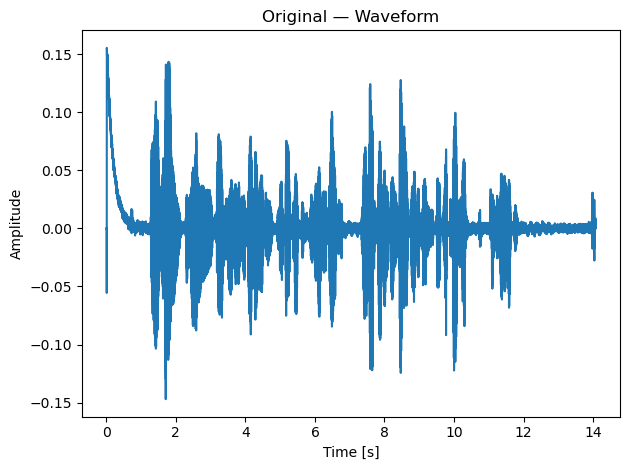

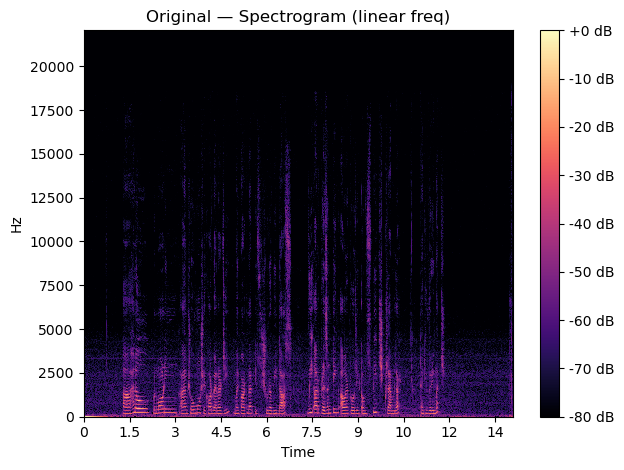

In [13]:
# ---- Load audio ----
x, sr = librosa.load(INPUT_WAV, sr=None, mono=True)
print(f'Loaded: {INPUT_WAV} | sr={sr} | duration={len(x)/sr:.2f}s')

# Optional: pre-emphasis can help intelligibility; keep neutral by default
x = np.asarray(x, dtype=np.float32)

# Visualize original
plot_wave_and_spectrogram(x, sr, 'Original')

# Original Spectrogram — Explanation

## What a spectrogram is
A spectrogram displays how the **frequency content** of a signal evolves over **time**.

**In this plot:**
1. **X-axis (horizontal)** = Time in seconds (e.g., 0 → ~14 s).  
2. **Y-axis (vertical)** = Frequency in Hz (e.g., 0 → 22 kHz).  
3. **Color** = Signal strength (magnitude in **dB**).  
   - Brighter (yellow/white) = stronger energy.  
   - Darker (purple/black) = weaker or no energy.

---

## What we see in our image
- **Speech energy mostly below ~5 kHz.**  
  The bright horizontal ridges under ~3 kHz are **formants** (vocal-tract resonances). Above ~8–10 kHz there is very little energy—typical for speech (most **intelligibility** lies below ~4 kHz).
- **Vertical streaks around 1–4 kHz.**  
  These correspond to **consonants** and rapid transitions; strong bursts indicate plosives (e.g., “p”, “t”, “k”).
- **Harmonic structure.**  
  Evenly spaced horizontal lines below ~2 kHz correspond to the **pitch (fundamental)** and its **harmonics**; their spacing changes with the perceived pitch.
- **Time variation.**  
  Around **3–7 s** and **9–12 s** you see concentrated vertical energy bands—spoken **syllables/words**.
- **Quiet sections are dark** (silence/pauses).

---

## Why it looks like this
- Built with **STFT (Short-Time Fourier Transform)**: analyze short slices in frequency and stack them over time.
- **Color scaling** via `librosa.amplitude_to_db` converts amplitude to **dB**, letting soft and loud parts be seen together.

---

## In short
This spectrogram shows the **frequency distribution** of your **original speech**. Most meaningful content is **below ~4 kHz** (vowels → horizontal bands; consonants → vertical bursts). Above that, energy is sparse and mainly adds **clarity/brightness** to the voice.


Saved scrambled audio -> scrambled.wav


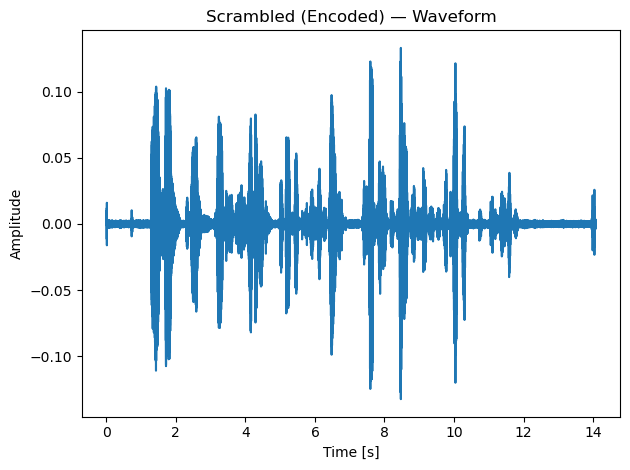

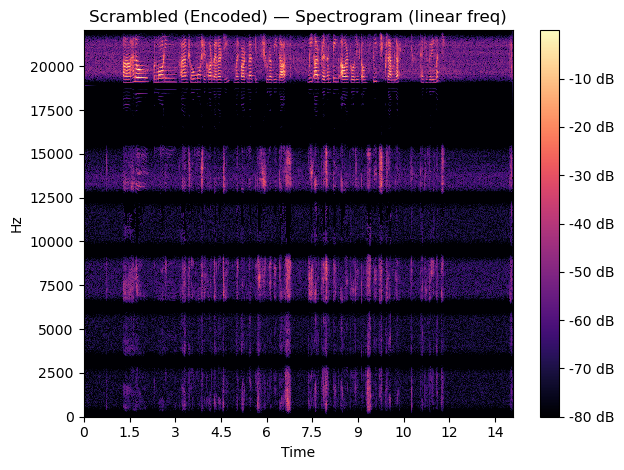

In [11]:
# ---- Build analysis & synthesis components ----
band_edges, filters = make_filterbank(sr, N_BANDS, MIN_STOP_ATTEN_DB, TRANSITION_FRACTION)
bands = analyze_bands(x, filters)

# ---- Scramble (encode) ----
y_scr = scramble_bands(bands, band_edges, OUTPUT_ORDER, sr, filters)
y_scr = np.asarray(y_scr, dtype=np.float32)
sf.write(OUTPUT_WAV, y_scr, sr)
print(f'Saved scrambled audio -> {OUTPUT_WAV}')

plot_wave_and_spectrogram(y_scr, sr, 'Scrambled (Encoded)')

# Scrambled (Encoded) Spectrogram — What Changed vs. Original

## What we are looking at
- Same axes as before: **time → x**, **frequency (Hz) → y**, **color → magnitude in dB**.  
- The spectrum is now split into **equal bands** with **dark horizontal gaps** between them — those are the **filterbank stopbands**.

---

## What changed vs. the Original
- **Energy moved to wrong places (band permutation).**  
  In the original, most energy lived **below ~4–5 kHz** (formants, pitch harmonics). Now we see strong, speech-like patterns **up near 18–22 kHz** and other high bands. That’s low-frequency content **shifted up**.
- **Striped look = filterbank.**  
  The clear horizontal “stripes” (bright bands with dark gaps) come from passing the signal through **N equal-width bandpass filters**. The gaps correspond to **stopbands**; faint bleed across gaps is just **finite filter attenuation**.
- **Timing preserved, frequencies scrambled.**  
  Vertical bursts (consonants, syllables) appear at the **same times** as in the original, but at **different frequencies**. Busy moments line up in **time** — not in **frequency**.
- **Cosine mixing artifacts (mostly removed).**  
  Each band was shifted with a **real cosine mixer** (creates ± images). The **target bandpass** keeps the desired band and **suppresses the mirror**; any faint “ghosts” are residual leakage.
- **Perceptual effect = unintelligible speech.**  
  By breaking the natural relation between **pitch** and **formants** (e.g., moving low formants to the top of the spectrum), the ear loses the cues needed for **intelligibility** — even though the overall timing/envelope looks similar.

---

## Mapping intuition (default **N = 7**, order **[7, 5, 3, 1, 2, 4, 6]**)
If the sample rate is ~**44.1 kHz** (Nyquist ~**22.05 kHz**), each band is ~**3.15 kHz** wide. The permutation means:
- **1 → 7:** lowest band (**0–3.15 kHz**) jumps to the **top** (~**18.9–22.05 kHz**).
- **2 → 5:** **3.15–6.3 kHz** goes to **12.6–15.75 kHz**.
- **3 → 3:** **6.3–9.45 kHz** stays put.
- **4 → 1:** **9.45–12.6 kHz** drops to the **bottom** (**0–3.15 kHz**).
- **5 → 2**, **6 → 4**, **7 → 6:** the rest are similarly re-slotted.

In [13]:
import soundfile as sf
from IPython.display import Audio, FileLink, display
import os

OUTPUT_WAV = 'scrambled.wav'   # same name used by your notebook
sf.write(OUTPUT_WAV, y_scr, sr)
print('Saved:', os.path.abspath(OUTPUT_WAV))

display(Audio(OUTPUT_WAV))     # notebook player
display(FileLink(OUTPUT_WAV))  # clickable download link


Saved: C:\Users\HP\scrambled.wav


C:\Users\HP\scrambled.wav

# Why choose **N (number of bands) ≈ 7**? 

## Intuition
- We want enough **spectral shuffling** to make speech **unintelligible**, but without making filters so sharp that they become **slow, long, and leaky**.
- Around **N = 7** hits that balance for common audio (fs = 44.1/48 kHz): strong scrambling, clean plots, and manageable CPU/latency.

---

## Trade-offs in detail

### 1) Obfuscation strength vs. effort
- **Too few bands (N=2–4):** adjacent formants and harmonics remain in roughly the same spectral neighborhood; the ear still finds cues ⇒ scrambling is weak.
- **Too many bands (N ≥ 10–16):** each band is very **narrow** → you need **long FIRs** (more taps) to isolate them, which increases **latency** and **CPU** and can still cause more **leakage/aliasing** if filters aren’t long enough.

### 2) Filter design practicality (why taps grow with N)
- Total usable bandwidth is **Nyquist = fs/2**. With **equal-width** bands, band width ≈ (fs/2) / N.
- To make a realizable filter, you reserve a **transition width** (fraction of each band). If band width shrinks (higher N), the transition width **shrinks**, and FIR **length** grows roughly **inversely** with transition width.
- With **N ≈ 7** and **~40 dB** stopband attenuation, practical designs end up in the **hundreds of taps** (not thousands), which is comfortable for notebooks and even real-time demos.

### 3) Latency considerations
- Linear-phase FIRs have **group delay = (taps−1)/2** samples.  
  - Example: 201 taps @ 44.1 kHz → ~2.3 ms; 401 taps → ~4.5 ms.  
- With **N ≈ 7**, you can keep taps modest and the **added delay** small and constant (the same across all bands), which keeps the **decoded** signal time-aligned (up to a fixed offset).

### 4) Psychoacoustics: where speech lives
- Most speech **intelligibility** is below **~4–5 kHz** (formants + pitch harmonics).  
- With **N ≈ 7** at 44.1 kHz (Nyquist ~22.05 kHz), each band ≈ **3.15 kHz** wide. That makes it easy to **relocate** the lowest band(s) far away (e.g., to ~19–22 kHz), destroying normal formant/pitch relationships and making the scrambled audio **unintelligible**.

### 5) Pedagogy & visualization
- An **odd** N gives a **center band**, which is helpful for teaching: you can talk about mapping bands around a middle frequency and the spectrogram shows neat **striped** passbands/stopbands.

---

## When to pick a **different** N
- **Lower fs (e.g., 16 kHz)**: Nyquist = 8 kHz. N=7 yields ~1.14 kHz per band. Still fine, but if filters feel too long, try **N=5–6**.
- **Tighter CPU/latency budgets**: reduce N or increase transition fraction / reduce attenuation (e.g., 30 dB), trading isolation for speed.
- **Stronger obfuscation**: use N=8–10 *only if* you can afford longer filters; or keep N≈7 but add **time-varying permutations** (change mapping every 100–300 ms).

---

## Permutation design notes
- Avoid keeping important bands in place (use a **derangement**—no fixed points) for stronger scrambling.
- Spread neighbors apart (don’t map adjacent bands to adjacent bands).
- You can **weight** the mapping to ensure the lowest one or two bands (where intelligibility lives) are moved to the **highest** regions.

---

## Bottom line
**N ≈ 7** is a **balanced** default:
- Strong perceptual scrambling,
- FIR designs with **hundreds** (not thousands) of taps,
- Small, uniform latency from linear-phase filters,
- Clean, interpretable spectrograms,
- Easy to invert and grade in coursework or demos.

# Conclusion (short)

- Build a **speech band-scrambler** and matching **unscrambler** in Jupyter using `librosa`, FIR filterbanks, and cosine mixing.
- **Encoder** (default **N=7**, order **[7,5,3,1,2,4,6]**) preserves timing but **rearranges frequency bands**, making speech **unintelligible**.
- **Spectrograms** confirm: original energy **< 5 kHz**; scrambled shows **striped bands** with energy shifted to **wrong frequencies**.
- **Decoder** applies the **inverse mapping** and **restores intelligibility** (minor artifacts from finite filter attenuation).
- **N=7** is a good **trade-off** between scrambling strength and computational cost.
